# Pre alpha lambeq model 

In this tutorial we will go through all the steps to run the pre alpha lambeq model for the case of a binary classfication. This model uses the lambeq library to perform a binary classification of sentences.

In [10]:
import sys
import os
import argparse
sys.path.append("./../../models/quantum/pre_alpha_2/")
sys.path.append("./../../data/data_processing/")
from pre_alpha_2 import *
from collections import Counter
import random
import pickle
import json
import time 
import torch 
from statistics import mean
from save_json_output import save_json_output
import pandas as pd 
import lambeq
import numpy as np
import discopy
import torch
torch.set_num_threads(40)
import pickle

We will set the following values for our benchmark: 

    - seed : Random seed for the initial parameters of the quantum circuit
    - optimiser : Optimiser to be used in the optimisation of the parameters of the quantum circuit
    - iterations : Number of iterations to be performed by the optimiser 
    - train : Directory of the train dataset
    - test : Directory of the test dataset 
    - output : Directory to store the results 
    - ansatz : Ansatz to be used on the quantum circuits 
    - qn : Number of qubits per noun type
    - qs : Number of qubits per sentence type 
    - nl : Number of layers of the circuits 
    - np : Number of variational parameters per circuit

This is an example so we will only run our models once. In the pipeline that implements the model another argument (runs) can be set to perform different initialisations of variational quantum parameters

In [11]:
seed = 1906
iterations = 250
train = './../../data/datasets/toy_dataset_train.tsv'
test = './../../data/datasets/toy_dataset_test.tsv'
output = './../../benchmarking/results/raw/'
ansatz = 'IQP'
qn = 1 
qs = 1 
nl = 1
np = 3
device = -1

We first load the training an testing dataset, and the prediction labels. 

In [12]:
sentences_train = PreAlpha2.load_dataset(train)[0]
labels_train = PreAlpha2.load_dataset(train)[1]
sentences_test = PreAlpha2.load_dataset(test)[0]
labels_test = PreAlpha2.load_dataset(test)[1]

After that we define a loss and accuracy functions and choose an optimiser. It is important to note that for a multiclass classification the loss function that is defined here is not valid. The optimizer will be one of the torch.optim.Optimizer.

In [13]:
def loss(y_hat, y):
    return torch.nn.functional.binary_cross_entropy(
        y_hat, y
    )
def acc(y_hat, y):
    return (torch.argmax(y_hat, dim=1) ==
        torch.argmax(y, dim=1)).sum().item()/len(y)
opt = torch.optim.Adam

Now we will load the diagrams representing each sentence. In our case we have them stored to save computing time on each run of the algorithm. 

In [14]:
with open('./../../data/datasets/diagrams_toy_dataset_train.pickle' , 'rb') as file:
    diagrams_train = pickle.load(file)
with open('./../../data/datasets/diagrams_toy_dataset_test.pickle' , 'rb') as file:
    diagrams_test = pickle.load(file)

We will now draw one of the diagrams as an example. We must note that for the case of our dataset we don't need to rewrite the sentences. 

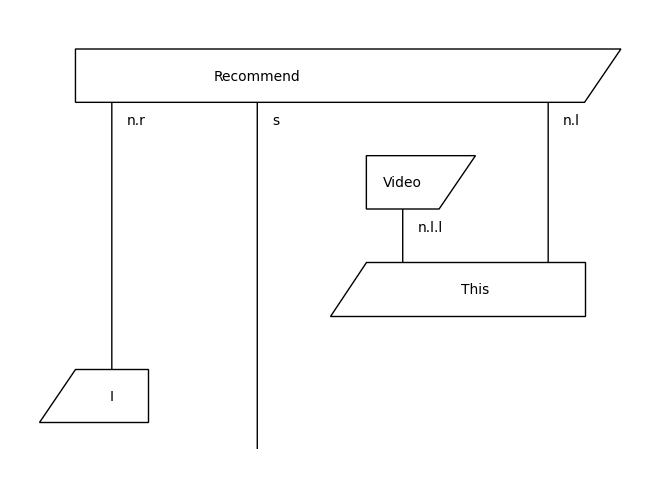

In [15]:
diagrams_train[1].draw()

We will now create the circuits for training and testing dataset. We can see how here we can customise our circuits with some of the parameters that we had defined above. 

In [16]:
circuits_train = PreAlpha2.create_circuits(
    diagrams_train, ansatz, qn,
    qs, nl, np
)
circuits_test = PreAlpha2.create_circuits(
    diagrams_test, ansatz, qn,
    qs, nl, np
)
all_circuits = circuits_test + circuits_train 


And we will draw the circuit that corresponds to the diagram we had already drawn above. 

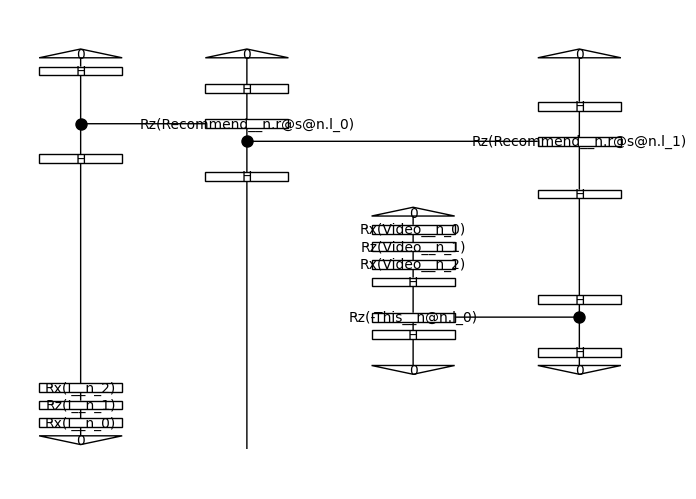

In [17]:
circuits_train[1].draw()

We create the datasets objects that lambeq needs to train, as well as the model and the trainer. In our case the model used is a PennylaneModel object. 


In [18]:
model = PreAlpha2.create_model(all_circuits)
trainer = PreAlpha2.create_trainer(
    model, loss, opt, iterations,
    {'acc': acc}, seed = seed, device = device
)
dataset_train = PreAlpha2.create_dataset(
    circuits_train, labels_train)
dataset_test = PreAlpha2.create_dataset(
    circuits_test, labels_test
)

We finally fit the model with our datasets : 

In [19]:
trainer.fit(dataset_train, dataset_test)

Epoch 1:    train/loss: 1.3108   valid/loss: 0.8302   train/acc: 0.4875   valid/acc: 0.8000
Epoch 2:    train/loss: 1.2804   valid/loss: 0.8311   train/acc: 0.5000   valid/acc: 0.8000
Epoch 3:    train/loss: 1.2516   valid/loss: 0.8322   train/acc: 0.5000   valid/acc: 0.8000
Epoch 4:    train/loss: 1.2243   valid/loss: 0.8333   train/acc: 0.5125   valid/acc: 0.7500
Epoch 5:    train/loss: 1.1982   valid/loss: 0.8346   train/acc: 0.5250   valid/acc: 0.7500
Epoch 6:    train/loss: 1.1734   valid/loss: 0.8359   train/acc: 0.5375   valid/acc: 0.7500
Epoch 7:    train/loss: 1.1495   valid/loss: 0.8373   train/acc: 0.5500   valid/acc: 0.7500
Epoch 8:    train/loss: 1.1267   valid/loss: 0.8388   train/acc: 0.5625   valid/acc: 0.7500
Epoch 9:    train/loss: 1.1047   valid/loss: 0.8402   train/acc: 0.5625   valid/acc: 0.7500
Epoch 10:   train/loss: 1.0836   valid/loss: 0.8416   train/acc: 0.5625   valid/acc: 0.7500
Epoch 11:   train/loss: 1.0632   valid/loss: 0.8430   train/acc: 0.5625   valid/

Final test accuracy: 0.65


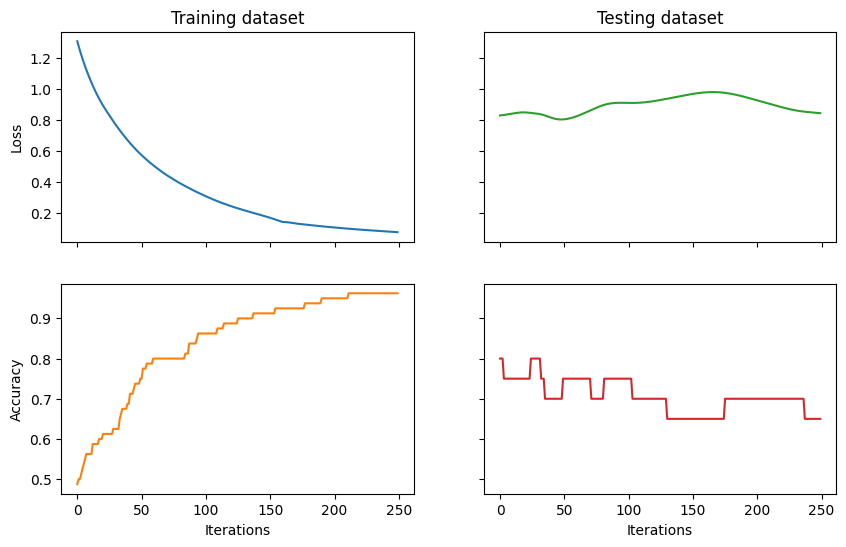

In [20]:
import matplotlib.pyplot as plt

fig, ((ax_tl, ax_tr), (ax_bl, ax_br)) = plt.subplots(2, 2,
                                                     sharex=True,
                                                     sharey='row',
                                                     figsize=(10, 6))
ax_tl.set_title('Training dataset')
ax_tr.set_title('Testing dataset')
ax_bl.set_xlabel('Iterations')
ax_br.set_xlabel('Iterations')
ax_bl.set_ylabel('Accuracy')
ax_tl.set_ylabel('Loss')

colours = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
ax_tl.plot(trainer.train_epoch_costs, color=next(colours))
ax_bl.plot(trainer.train_results['acc'], color=next(colours))
ax_tr.plot(trainer.val_costs, color=next(colours))
ax_br.plot(trainer.val_results['acc'], color=next(colours))

# print test accuracy
pred = model(circuits_test)
labels = torch.tensor(labels_test)

print('Final test accuracy: {}'.format(acc(pred, labels)))